# Convolutional Neural Networks (CNNs)
We have now learned about the Perceptron, Linear and logistic regression, Multi-layer perceptron and backpropagation, Auto-encoders. 

In this pratical session about Convolutional Neural Networks (CNNs) we will use the MNIST datasets.

First, we will obtain baselines using a Logistic Regression and a Feed-forward Neural Network.

## 0.0 - Imports
We will need to import some libraries to be used in this session. Libraries include data visualizers ([matplotlib](https://matplotlib.org/)), neural network package ([torch](https://pytorch.org/)), and other helper packages for data handling ([sklearn](https://scikit-learn.org/), [numpy](https://numpy.org/)).

In [1]:
%pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time
import copy

Then, other variable definitions are needed to be set. This includes the size of the dataset we will use, and the configuration of the GPU to be activated:

In [3]:
# Configure Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### 0.1 - Create Dataloaders
#### MNIST dataset 
Using torchvision we can easily download and use the MNIST dataset to create our train and validation dataloaders

In [5]:
# Define tranform - Convert data to tensor and normalize using dataset mean and std
mnist_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

mnist_transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomAffine(0, translate=[0.1, 0]),
     transforms.Normalize((0.1307,), (0.3081,))])

# Download and create MNIST train and validation dataloaders
mnist_train_dataset = datasets.MNIST('../data', download=True, train=True, transform=mnist_transform)
mnist_val_dataset = datasets.MNIST('../data', download=True, train=False, transform=mnist_transform) #transform=mnist_transform_test) # 
#mnist_val_dataset = datasets.MNIST('../data', download=True, train=False, transform=mnist_transform_test)
mnist_train_dataloader = DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
mnist_val_dataloader = DataLoader(mnist_val_dataset, batch_size=64, shuffle=True)

# MNIST Dataloaders to get data into numpy for Logistic Regression
mnist_train_dataloader_numpy = DataLoader(mnist_train_dataset, batch_size=len(mnist_train_dataset))
mnist_val_dataloader_numpy = DataLoader(mnist_val_dataset, batch_size=len(mnist_val_dataset))
X_y_train = next(iter(mnist_train_dataloader_numpy))
X_y_val = next(iter(mnist_val_dataloader_numpy))
X_train = X_y_train[0].numpy()
y_train = X_y_train[1].numpy()
X_val = X_y_val[0].numpy()
y_val = X_y_val[1].numpy()

dataloaders = dict(train=mnist_train_dataloader, val=mnist_val_dataloader)


We can check the MNIST dataset properties such as:

- shape of train and validation datasets - \[number of samples, width, height\]
- number of input feature on the flattened/reshaped input for Logistic Regression or MLP
- shape of train and validation batches - \[batch size, number of channels, width, height\]

In [6]:
# get batch to extract properties and plot example images
# next(enumerator(dataloader)) -> creates an iterator of the dataloader and gets the next batchß
batch_idx, (example_imgs, example_targets) = next(enumerate(mnist_train_dataloader))
# info about the dataset
D_in = np.prod(example_imgs.shape[1:])
D_out = len(mnist_train_dataloader.dataset.targets.unique())
print("Datasets shapes:", {x: dataloaders[x].dataset.data.shape for x in ['train', 'val']})
print("N input features:", D_in, "Output classes:", D_out)
print("Train batch:", example_imgs.shape, example_targets.shape)
batch_idx, (example_imgs, example_targets) = next(enumerate(mnist_val_dataloader))
print("Val batch:", example_imgs.shape, example_targets.shape)

Datasets shapes: {'train': torch.Size([60000, 28, 28]), 'val': torch.Size([10000, 28, 28])}
N input features: 784 Output classes: 10
Train batch: torch.Size([64, 1, 28, 28]) torch.Size([64])
Val batch: torch.Size([64, 1, 28, 28]) torch.Size([64])


We can plot some examples with corresponding labels using the following function. This function can also receive the predicted labels.

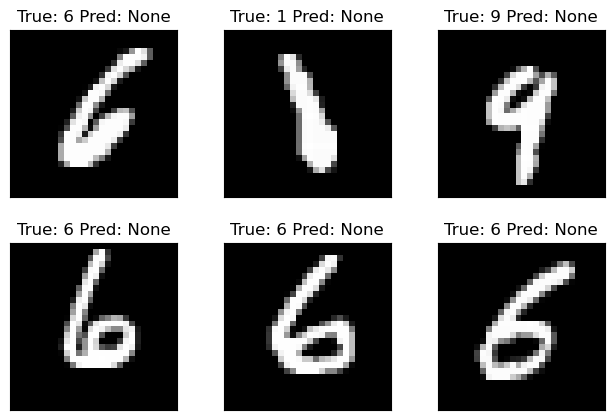

In [7]:
def plot_img_label_prediction(imgs, y_true, y_pred=None, shape=(2, 3)):
    y_pred = [None] * len(y_true) if y_pred is None else y_pred
    fig = plt.figure()
    for i in range(np.prod(shape)):
        plt.subplot(*shape, i+1)
        plt.tight_layout()
        plt.imshow(imgs[i][0], cmap='gray', interpolation='none')
        plt.title("True: {} Pred: {}".format(y_true[i], y_pred[i]))
        plt.xticks([])
        plt.yticks([])

plot_img_label_prediction(imgs=example_imgs, y_true=example_targets, y_pred=None, shape=(2, 3))


### 1.1 Logistic Regression

We can use a very simple Logistic Regression that receives our input images as a vector and predicts the digit. This will be our first baseline to compare with the CNNs.

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(np.reshape(X_train, (X_train.shape[0], -1)))
X_val = scaler.transform(np.reshape(X_val, (X_val.shape[0], -1)))

clf = LogisticRegression(C=50., multi_class='multinomial', solver='sag', tol=0.1)
clf.fit(X_train, y_train)
score = clf.score(X_val, y_val)

print("Test score with penalty: %.4f" % score)

/Users/simaonovais/miniconda3/envs/MLCatolica24/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test score with penalty: 0.8998


We can select the coefficients for each class and reshape them into the image shape to plot them. This allows us to visualize what are the pixels that are contributing more to the classification for each of the digits. 

But what happens if the digits are not centered? Will we still get such a good performance? Lets test that out later!

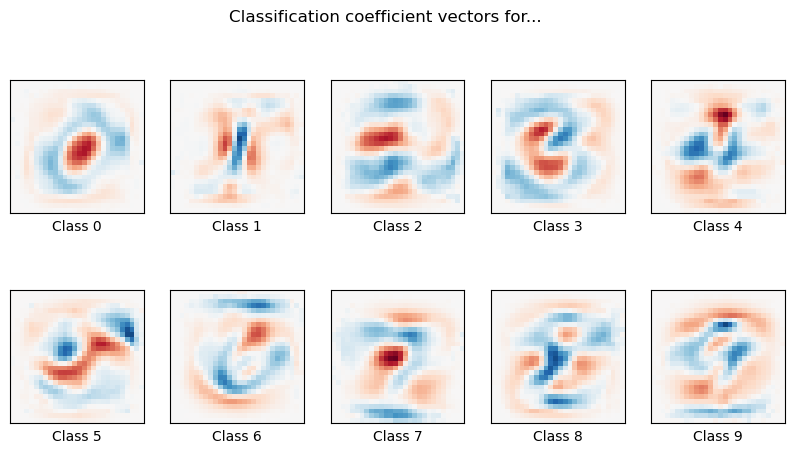

In [9]:
coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification coefficient vectors for...')

plt.show()

### 1.2 Feed-Forward Neural Network

The first step is to create the functions that will allow us to implement a feed-forward neural network and manage the training and validation process.

The MLP class will define the architecture of a feed-forward neural network, with a set of hidden layers (fully connected layers [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)), with a activation function in between them ([relu](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html#torch.nn.functional.relu)), and a [softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html#torch.nn.functional.log_softmax) in the last layer. Since the dataset poses a multiclass classification problem, the last layer should have a number of neurons equal to the number of classes.

In [13]:
class MLP(nn.Module):
    def __init__(self, dim_layers):
        super(MLP, self).__init__()
        self.dim_layers = dim_layers
        layer_list = [nn.Linear(dim_layers[l], dim_layers[l+1]) for l in range(len(dim_layers) - 1)]
        self.lin_layers = nn.ModuleList(layer_list)

    def forward(self, X):
        X = X.view(-1, self.dim_layers[0])
        # apply relu
        for layer in self.lin_layers[:-1]:
            X = F.relu(layer(X))
        # use softmax for output layer
        return F.log_softmax(self.lin_layers[-1](X), dim=1)

##### training validation function for the MLP and CNN

In [14]:
def train_val_model(model, criterion, optimizer, dataloaders, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # init dictionaries to save losses and accuracies of training and validation
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    for epoch in range(num_epochs):
        if log_interval is not None and epoch % log_interval == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # execute a training and validation phase for each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to train mode
            else:
                model.eval()   # Set model to eval mode

            running_loss = 0.0
            running_corrects = 0

            # iterate over the data
            nsamples = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                nsamples += inputs.shape[0]

                # set the parameter gradients to zero
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # if in training phase, perform backward prop and optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # increment loss and correct counts
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and epoch % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                    phase, epoch_loss, 100 * epoch_acc))

            # deep copy the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if log_interval is not None and epoch % log_interval == 0:
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(100 * best_acc))

    # load best model weights to return
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies

We will start by creating a simple network with some hidden layers. Thus, in addition to the input, it will have 3 fully connected layer which, in this implemetation, is assigned to the input of the MLP Class. We will use the Stochastic Gradient Descend optimizer ([optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)) with 0.01 learning rate and 0.5 momentum. The loss function to be optimized will be negative log likelihood ([nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)). Training and validation will be managed by the function "train_val_model" previously define.

Epoch 0/14
----------
train Loss: 0.7913 Acc: 77.19%
val Loss: 0.2928 Acc: 91.79%

Epoch 2/14
----------
train Loss: 0.1767 Acc: 94.81%
val Loss: 0.1506 Acc: 95.43%

Epoch 4/14
----------
train Loss: 0.1074 Acc: 96.87%
val Loss: 0.1025 Acc: 96.81%

Epoch 6/14
----------
train Loss: 0.0737 Acc: 97.84%
val Loss: 0.0873 Acc: 97.29%

Epoch 8/14
----------
train Loss: 0.0530 Acc: 98.45%
val Loss: 0.0761 Acc: 97.77%

Epoch 10/14
----------
train Loss: 0.0394 Acc: 98.84%
val Loss: 0.0710 Acc: 97.91%

Epoch 12/14
----------
train Loss: 0.0285 Acc: 99.24%
val Loss: 0.0704 Acc: 97.81%

Epoch 14/14
----------
train Loss: 0.0201 Acc: 99.50%
val Loss: 0.0695 Acc: 97.94%

Training complete in 0m 42s
Best val Acc: 97.94%


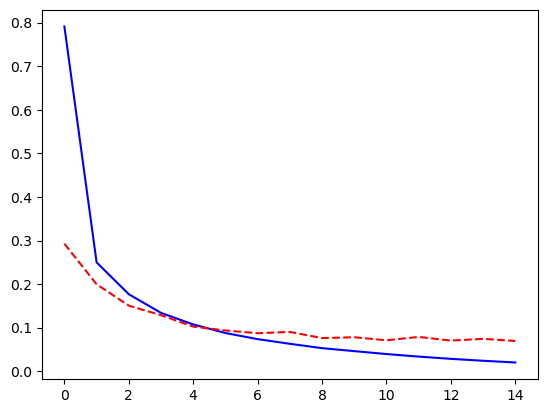

In [15]:
model_mlp = MLP([D_in, 256, 128, 64, D_out]).to(device) # [D_in, 512, 256, 128, 64, D_out]

optimizer = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

model_mlp, losses, accuracies = train_val_model(model_mlp, criterion, optimizer, dataloaders,
                       num_epochs=15, log_interval=2)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

### 1.3 Convolutional Neural Network

Convolutional layers capture patterns corresponding to relevant features independently of where they occur in the input. To do so, they slide a window over the input and apply the convolution operation with a set of kernels or filters that represent the features. Although it is not their only field of application, convolutional neural networks are mainly praised for their performance on image processing tasks.

The training and validation management for the CNN implementation will be performed as the feed-forward network, however we will have to define the network's architecture.

For that we will implement a CNN class to define how many layers it comprises and how the layers will be connected.

The initialization (`__init__`) function will define the architecture and the `foward` function will implement how the different layers are connected. This architecture will be a sequece of 2 convolutional layers ([nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) (1st: output channels 10, kernel size 5; 2nd: output channels 20, kernel size 5), then 2 fully connected layers ([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) (1st: output features 50; 2nd: output features 10 (the number of classes)). Once again, the final layer will be a [softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html#torch.nn.functional.log_softmax) function  that will choose the most probable class of the 10 in the input.

Between the second convolution layer and the first fully connected, we will set a dropout layer ([nn.Dropout2d](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html)). The idea behind dropout is to disable a percentage of randomly selected neurons during each step of the training phase, in order to avoid overfitting.

In [16]:
class CNN(nn.Module):
    """Basic Pytorch CNN for MNIST-like data."""

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, T=1.0):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

As previously, lets describe the model to be trained. We will use the ADAM optimizes ([optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)), with learning rate 0.001, and the same negative log likelihood ([nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)).

In [17]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
                       num_epochs=25, log_interval=2)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

Epoch 0/24
----------
train Loss: 0.5295 Acc: 83.49%
val Loss: 0.0903 Acc: 97.17%

Epoch 2/24
----------
train Loss: 0.2078 Acc: 93.97%
val Loss: 0.0524 Acc: 98.39%

Epoch 4/24
----------
train Loss: 0.1648 Acc: 95.15%
val Loss: 0.0433 Acc: 98.54%

Epoch 6/24
----------
train Loss: 0.1468 Acc: 95.71%
val Loss: 0.0403 Acc: 98.66%

Epoch 8/24
----------
train Loss: 0.1380 Acc: 95.93%
val Loss: 0.0378 Acc: 98.78%



KeyboardInterrupt: 

We have now completed training and validation with 3 different models: Logistic Regression, Feed-Forward Network, and Convolutional Neural Network. 

We have seen that with the CNN, the performance of the model in the validation set, outperforms the other models (~99% accuracy against ~90% and ~98%). 

The difference in performance between CNNs and MLP is small but how many learnable parameters are we using in the MLP and in CNN models?

We can find it out using the following lines of code:

In [18]:
#model_mlp = MLP([D_in, 256, 128, 64, D_out]).to(device)
model_parameters_mlp = filter(lambda p: p.requires_grad, model_mlp.parameters())
params_mlp = sum([np.prod(p.size()) for p in model_parameters_mlp])
print('Number of parameters in the MLP model: {}'.format(params_mlp))

model_parameters_cnn = filter(lambda p: p.requires_grad, model.parameters())
params_cnn = sum([np.prod(p.size()) for p in model_parameters_cnn])
print('Number of parameters in the CNN model: {}'.format(params_cnn))

Number of parameters in the MLP model: 242762
Number of parameters in the CNN model: 21840


You can see that we have ~11x more learnable parameters to achieve almost the same performance.

We can experiment and try to find out the number of layers and corresponding sizes.

In [19]:
model_mlp_test = MLP([D_in, 32, D_out]).to(device)
model_parameters_mlp_test = filter(lambda p: p.requires_grad, model_mlp_test.parameters())
params_mlp_test = sum([np.prod(p.size()) for p in model_parameters_mlp_test])
print('Number of parameters in the MLP model: {}'.format(params_mlp_test))

Number of parameters in the MLP model: 25450


And how does that model perform? We are about to find out

Epoch 0/14
----------
train Loss: 0.4769 Acc: 86.93%
val Loss: 0.2862 Acc: 92.03%

Epoch 5/14
----------
train Loss: 0.1517 Acc: 95.61%
val Loss: 0.1477 Acc: 95.50%

Epoch 10/14
----------
train Loss: 0.1066 Acc: 96.93%
val Loss: 0.1218 Acc: 96.43%

Training complete in 0m 34s
Best val Acc: 96.91%


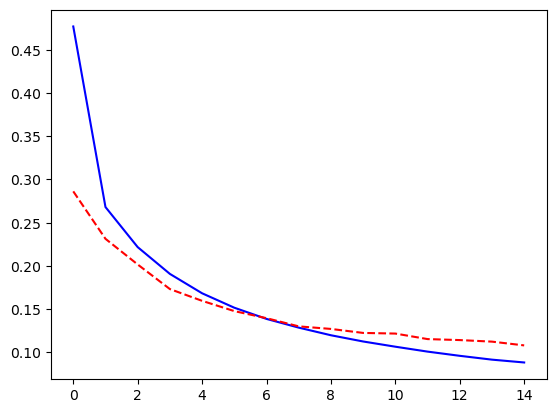

In [20]:
optimizer = optim.SGD(model_mlp_test.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

model_mlp_test, losses, accuracies = train_val_model(model_mlp_test, criterion, 
                                                     optimizer, dataloaders,
                                                     num_epochs=15, 
                                                     log_interval=5)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

We can see a drop in performance compared with the previous MLP model. So we can understand that although we have less learnable parameters, due to properties of CNNs (e.g., invariance and parameter sharing), which allow them to have fewer weights as some parameters are shared.

CNNs are expected to be invariant to the location where important features occur in the input. In fact, it's not unusual that there is a dataset shift where the data acquisition process suffers some modification. We will do this by applying a transformation with horizontal translations to our validation dataset and see how robust each model is to these shifts.

We can do this by going back to **0.1 - Create Dataloaders -
MNIST dataset** cell to define the test transform using the following code 

```
mnist_transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomAffine(0, translate=[0.1, 0]),
     transforms.Normalize((0.1307,), (0.3081,))])
```

and replace

`mnist_val_dataset = datasets.MNIST('../data', download=True, train=False, transform=mnist_transform)`

with

`mnist_val_dataset = datasets.MNIST('../data', download=True, train=False, transform=mnist_transform_test)`

After rerunning the different models we can see that the accuracy of the Logistic Regression drops from ~90% to ~72%, the MLP drops from ~98% to ~87%, and the CNN drops from ~99% to ~97%. This shows that the learned features are more robust to variances in location, as expected.